#Mounting Google Drive

In [26]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading all txt files into single dataframe

In [27]:
import os
import pandas as pd

# Define the path to the main directory containing the folders
main_directory = '/content/drive/MyDrive/bbc-fulltext/bbc'

# List of folder names
folders = ['tech', 'politics', 'sport', 'business', 'entertainment']

# Initialize an empty list to store data
data = []

# Iterate through each folder and read the text files
for folder in folders:
    folder_path = os.path.join(main_directory, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                data.append([content, folder])

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['Content', 'Category'])

df.head()


,Content,Category
0,PlayStation 3 chip to be unveiled\n\nDetails o...,tech
1,Security scares spark browser fix\n\nMicrosoft...,tech
2,Finding new homes for old phones\n\nRe-using o...,tech
3,Britons fed up with net service\n\nA survey co...,tech
4,Global blogger action day called\n\nThe global...,tech


#Importing Libraries

In [28]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [29]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Text processing functions

In [30]:
def clean_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    return ' '.join(text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stop_words])

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Process the text
df['Content'] = df['Content'].apply(clean_text)
df['Content'] = df['Content'].apply(remove_stopwords)
df['Content'] = df['Content'].apply(lemmatize_text)
df.head()

,Content,Category
0,playstation 3 chip unveiled detail chip design...,tech
1,security scare spark browser fix microsoft wor...,tech
2,finding new home old phone re-using old mobile...,tech
3,briton fed net service survey conducted pc pro...,tech
4,global blogger action day called global web bl...,tech


#EDA

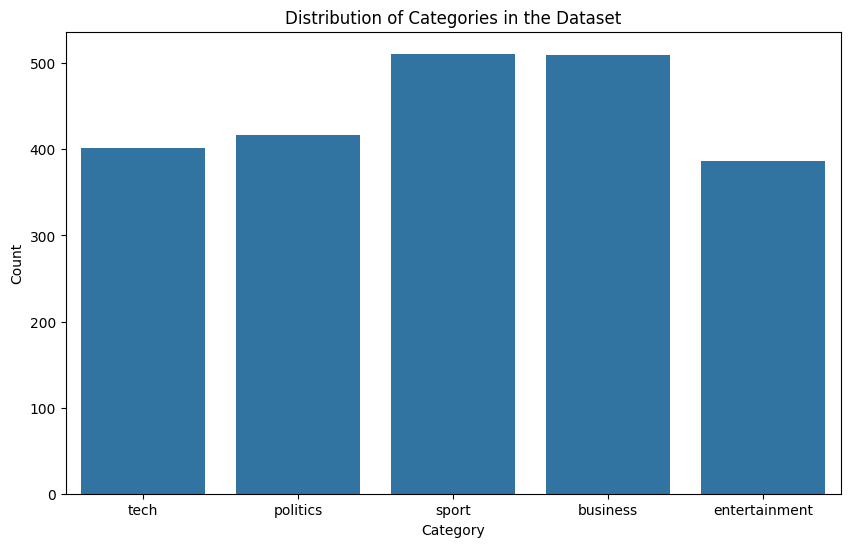

In [31]:

# 1. Distribution of Categories in the Dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='Category', data=df)
plt.title('Distribution of Categories in the Dataset')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

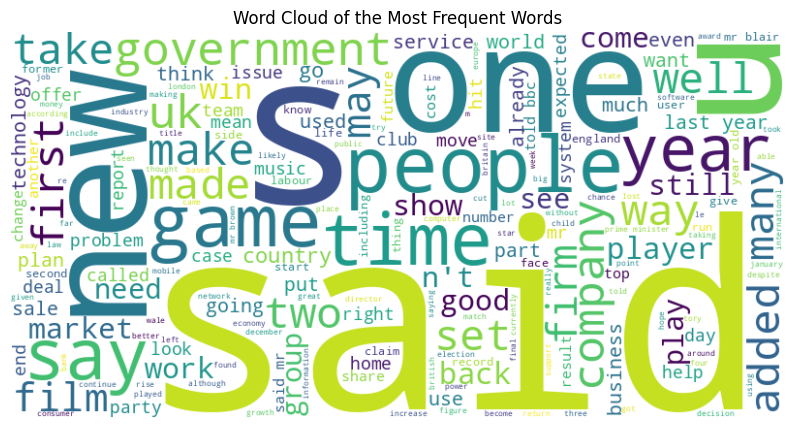

In [32]:
# 2. Word Cloud of the Most Frequent Words
text = ' '.join(df['Content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of the Most Frequent Words')
plt.axis('off')
plt.show()

In [33]:
# Encode labels
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

In [34]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Category'], test_size=0.2, random_state=42)

# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [39]:
# Train Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluation metrics function
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Evaluate models
metrics_nb = evaluate_model(y_test, y_pred_nb)
metrics_rf = evaluate_model(y_test, y_pred_rf)

print("Naive Bayes - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(*metrics_nb))
print("Random Forest - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(*metrics_rf))

# Prepare data for CNN
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# Train CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train_pad, y_train, epochs=6, batch_size=32, validation_split=0.2)





Naive Bayes - Accuracy: 0.96, Precision: 0.96, Recall: 0.96, F1-score: 0.95
Random Forest - Accuracy: 0.95, Precision: 0.95, Recall: 0.95, F1-score: 0.95
Epoch 1/6
45/45 [==============================] - 2s 25ms/step - loss: 1.5547 - accuracy: 0.3265 - val_loss: 1.4302 - val_accuracy: 0.4719
Epoch 2/6
45/45 [==============================] - 1s 21ms/step - loss: 1.0112 - accuracy: 0.7633 - val_loss: 0.6383 - val_accuracy: 0.8371
Epoch 3/6
45/45 [==============================] - 1s 22ms/step - loss: 0.2832 - accuracy: 0.9480 - val_loss: 0.3303 - val_accuracy: 0.9017
Epoch 4/6
45/45 [==============================] - 1s 21ms/step - loss: 0.0607 - accuracy: 0.9937 - val_loss: 0.2783 - val_accuracy: 0.9129
Epoch 5/6
45/45 [==============================] - 1s 21ms/step - loss: 0.0165 - accuracy: 0.9993 - val_loss: 0.2600 - val_accuracy: 0.9129
Epoch 6/6
45/45 [==============================] - 1s 22ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.2554 - val_accuracy: 0.9073


In [42]:
# Evaluate CNN model
y_pred_prob = cnn_model.predict(X_test_pad)
y_pred_cnn = np.argmax(y_pred_prob, axis=1)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_pad, y_test)
metrics_cnn = evaluate_model(y_test, y_pred_cnn)

14/14 [==============================] - 0s 6ms/step - loss: 0.2575 - accuracy: 0.9191


In [43]:
print("Naive Bayes - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(*metrics_nb))
print("Random Forest - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(*metrics_rf))

print("CNN - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-score: {:.2f}".format(*metrics_cnn))

Naive Bayes - Accuracy: 0.96, Precision: 0.96, Recall: 0.96, F1-score: 0.95
Random Forest - Accuracy: 0.95, Precision: 0.95, Recall: 0.95, F1-score: 0.95
CNN - Accuracy: 0.92, Precision: 0.92, Recall: 0.92, F1-score: 0.92


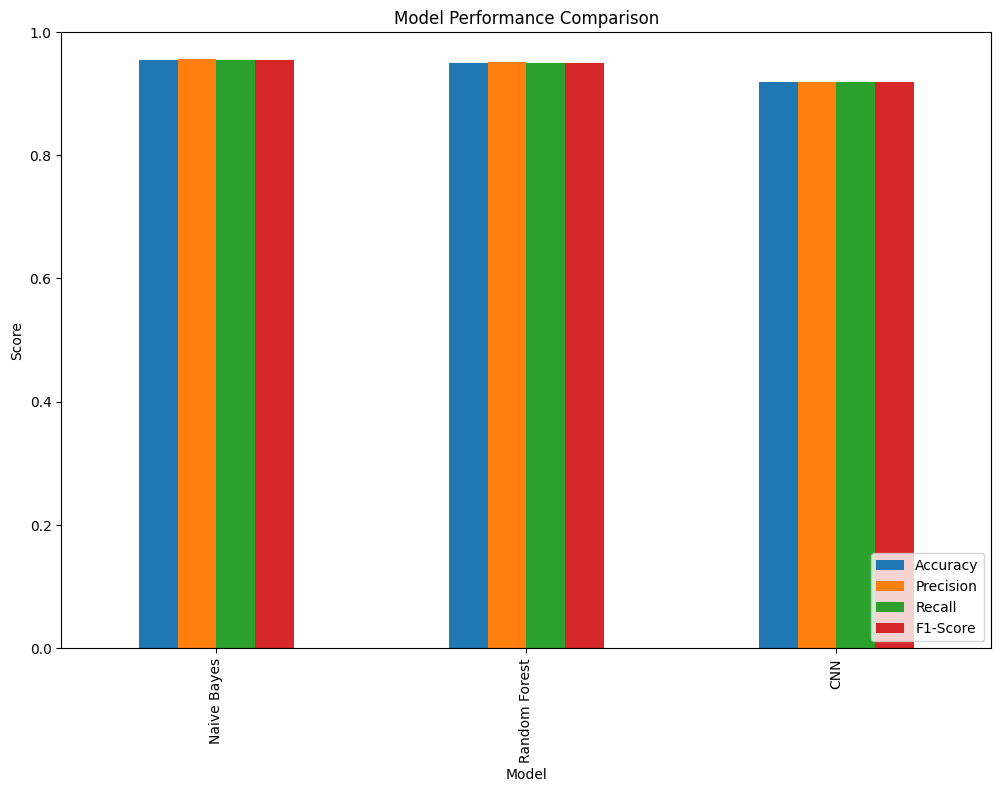

In [44]:
# Create a DataFrame for comparison
metrics_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Random Forest', 'CNN'],
    'Accuracy': [metrics_nb[0], metrics_rf[0], metrics_cnn[0]],
    'Precision': [metrics_nb[1], metrics_rf[1], metrics_cnn[1]],
    'Recall': [metrics_nb[2], metrics_rf[2], metrics_cnn[2]],
    'F1-Score': [metrics_nb[3], metrics_rf[3], metrics_cnn[3]]
})

# Plot the comparison
metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Implementing the recommender system
def recommend_news(user_interest, top_n=5):
    filtered_news = df[df['Category'] == user_interest]
    return filtered_news.head(top_n)

# Example of recommending news based on user interest
user_interest = 'tech'
recommended_news = recommend_news(user_interest)
print(recommended_news)
